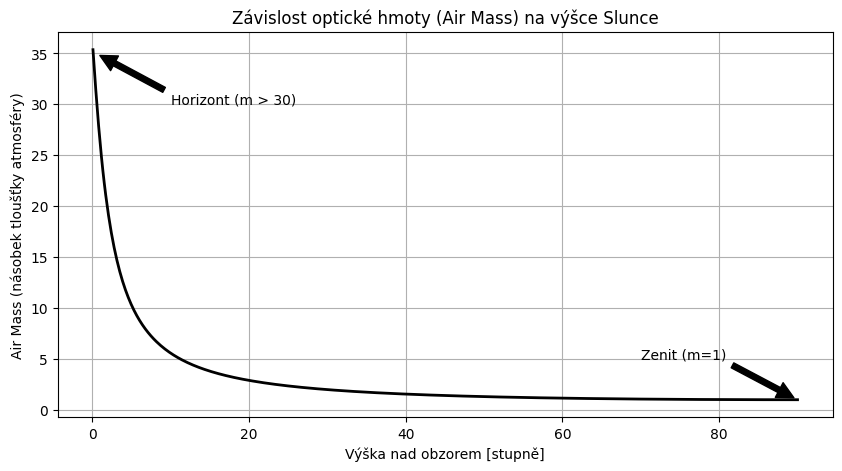

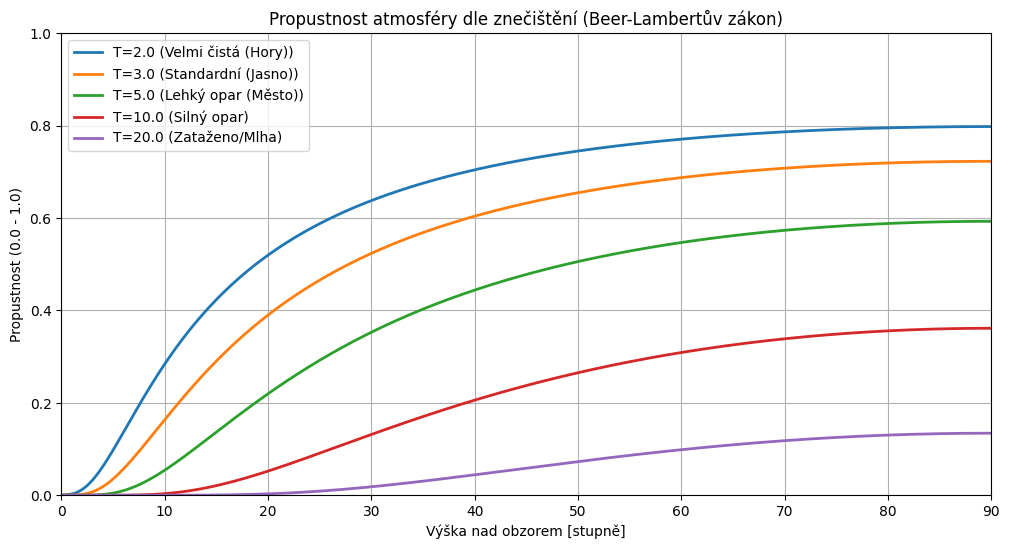

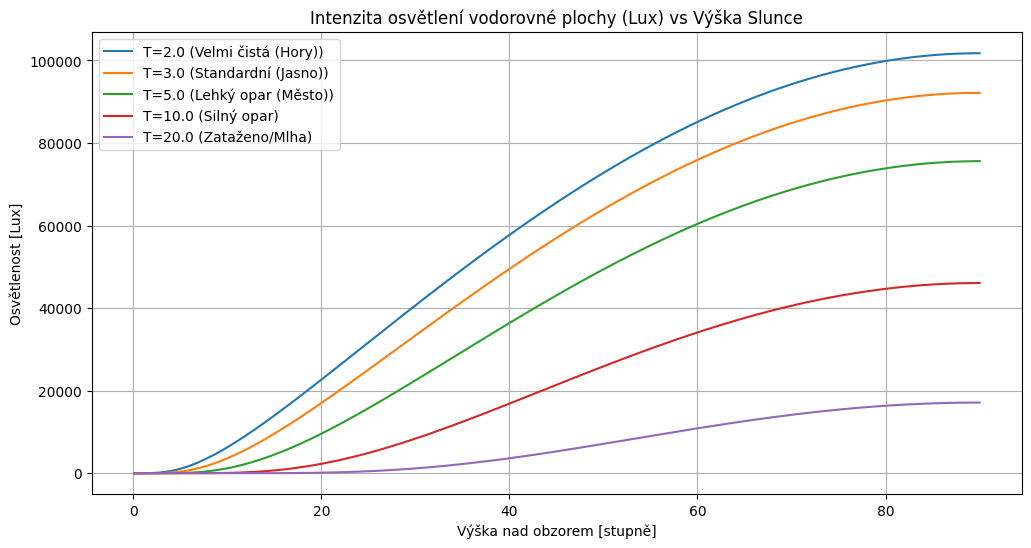

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Přidání cesty k src
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

from illumination_model.atmosphere import AtmosphereModel
from illumination_model.sources.sun import SunModel
from skyfield.api import load

# 1. Inicializace
atmos = AtmosphereModel()
sun = SunModel()

# Vytvoříme rozsah výšek nad obzorem (od horizontu 0° po zenit 90°)
altitudes = np.linspace(0.1, 90, 500) # Začínáme kousek nad 0, kvůli grafům

# --- GRAF 1: Optická vzdušná hmota (Air Mass) ---
air_masses = [atmos._calculate_air_mass(alt) for alt in altitudes]

plt.figure(figsize=(10, 5))
plt.plot(altitudes, air_masses, 'k-', linewidth=2)
plt.title('Závislost optické hmoty (Air Mass) na výšce Slunce')
plt.xlabel('Výška nad obzorem [stupně]')
plt.ylabel('Air Mass (násobek tloušťky atmosféry)')
plt.grid(True)
plt.annotate('Zenit (m=1)', xy=(90, 1), xytext=(70, 5),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Horizont (m > 30)', xy=(0.5, 35), xytext=(10, 30),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

# --- GRAF 2: Propustnost atmosféry pro různé počasí (Turbidita) ---
turbidities = {
    2.0: "Velmi čistá (Hory)",
    3.0: "Standardní (Jasno)",
    5.0: "Lehký opar (Město)",
    10.0: "Silný opar",
    20.0: "Zataženo/Mlha"
}

plt.figure(figsize=(12, 6))

for t_val, label in turbidities.items():
    transmittances = [atmos.get_transmittance(alt, turbidity=t_val) for alt in altitudes]
    plt.plot(altitudes, transmittances, label=f'T={t_val} ({label})', linewidth=2)

plt.title('Propustnost atmosféry dle znečištění (Beer-Lambertův zákon)')
plt.xlabel('Výška nad obzorem [stupně]')
plt.ylabel('Propustnost (0.0 - 1.0)')
plt.legend()
plt.grid(True)
plt.xlim(0, 90)
plt.ylim(0, 1)
plt.show()

# --- GRAF 3: Finální dopadající Luxy (Slunce + Atmosféra) ---
# Předpokládejme průměrnou intenzitu Slunce nad atmosférou (cca 127.5 kLux)
# Zde si "půjčíme" hodnotu konstanty přímo, pro účely grafu nepotřebujeme přesné datum
solar_raw = SunModel.SOLAR_CONSTANT_LUX 

plt.figure(figsize=(12, 6))

for t_val, label in turbidities.items():
    # E_surface = E_exo * transmittance * sin(alpha)
    # POZOR: Článek v Eq 20 násobí cos(theta_s), což je sin(altitude).
    # Toto je "Horizontal Illuminance" - osvětlení vodorovné plochy (země).
    
    lux_values = []
    for alt in altitudes:
        trans = atmos.get_transmittance(alt, turbidity=t_val)
        # Projekce na vodorovnou plochu (Lambertův zákon pro dopad): sin(alt)
        lux_horizontal = solar_raw * trans * np.sin(np.radians(alt))
        lux_values.append(lux_horizontal)

    plt.plot(altitudes, lux_values, label=f'T={t_val} ({label})')

plt.title('Intenzita osvětlení vodorovné plochy (Lux) vs Výška Slunce')
plt.xlabel('Výška nad obzorem [stupně]')
plt.ylabel('Osvětlenost [Lux]')
plt.legend()
plt.grid(True)
plt.show()